<a href="https://colab.research.google.com/github/IbalArrasyid/indoBert-sentiment-analysis/blob/main/Setimen_Analisis_Tokopedia_Review_v1_Spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tugas Big Data

Nama : M. Iqbal Arrasyid <br>
NIM : 1304221038

# Sentiment Analysis Tokopedia Reviews using Apache Spark

## Setup & Imports

In [68]:
# import library pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType
import re

In [69]:
# inisialisasi sesi spark
spark = SparkSession.builder \
    .appName("TokopediaSentimentAnalysis") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

## Load Data

In [70]:
# import dataset
df = spark.read.option("header", "true").csv("product_reviews_dirty.csv")
df.show(5)


+---+--------------------+------+-----------+--------------------+----------+----+-------+--------------------+
|_c0|                text|rating|   category|        product_name|product_id|sold|shop_id|         product_url|
+---+--------------------+------+-----------+--------------------+----------+----+-------+--------------------+
|  1|Barang sesuai pes...|     5|pertukangan|Staples Dekorasi ...| 418660637|   1|1740837|https://www.tokop...|
|  2|Barang bagus harg...|     5|pertukangan|STAPLE GUN ATS 3 ...| 416032545|  11|1477109|https://www.tokop...|
|  3|Paket rapi...mant...|     5|pertukangan|STAPLE GUN ATS 3 ...| 416032545|  11|1477109|https://www.tokop...|
|  4|ya saya puas dgn ...|     5|pertukangan|ALAT STAPLES TEMB...| 102279869|   5| 771395|https://www.tokop...|
|  5|Responya luar bia...|     5|pertukangan|Isi Refill Staple...| 190679689| 787| 969999|https://www.tokop...|
+---+--------------------+------+-----------+--------------------+----------+----+-------+--------------

In [71]:
df.count()

43935

Disini terdapat 43.935 baris pada dataset

## Preprocessing

In [72]:
# membersihkan text
def clean_text(text):
    if text:
        text = text.lower()
        text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
        text = re.sub(r"\s+", " ", text).strip()
        return text
    return ""

clean_udf = udf(clean_text, StringType())
df_cleaned = df.withColumn("cleaned_text", clean_udf(col("text")))
df_cleaned.select("text", "cleaned_text").show(5)


+--------------------+--------------------+
|                text|        cleaned_text|
+--------------------+--------------------+
|Barang sesuai pes...|barang sesuai pes...|
|Barang bagus harg...|barang bagus harg...|
|Paket rapi...mant...|paket rapimantapc...|
|ya saya puas dgn ...|ya saya puas dgn ...|
|Responya luar bia...|responya luar bia...|
+--------------------+--------------------+
only showing top 5 rows



Disini kita sudah berhasil membersihkan data dari simbol, angka, dan spasi berlebih. Lalu kita juga sudah mernormalisasikan data ke huruf kecil semua agar seragam.

## Sentiment Analysis

In [73]:
from transformers import pipeline
import pandas as pd
from pyspark.sql.functions import pandas_udf, col
from pyspark.sql.types import StringType

# fungsi sentimen
def get_sentiment_indobert(texts: pd.Series) -> pd.Series:
    # load indobert
    classifier = pipeline("sentiment-analysis", model="w11wo/indonesian-roberta-base-sentiment-classifier")

    def _analyze_single_text(text):
        if text:
            try:
                # Batasi ke 512 token (as before)
                result = classifier(text[:512])[0]
                return result['label'].lower()
            except:
                # handle potensial error saat proses sentimen
                return "neutral"
        # handle none atau teks kosong
        return "neutral"

    return texts.apply(_analyze_single_text)


# mendefinisikan pandas untuk spark
@pandas_udf(StringType())
def sentiment_udf_udf(texts: pd.Series) -> pd.Series:
    # Call the analysis function defined above
    return get_sentiment_indobert(texts)


# memakai udf untuk proses pembersihan teks

df_final = df_cleaned.withColumn("sentiment", sentiment_udf_udf(col("cleaned_text")))
df_final.show(5)

+---+--------------------+------+-----------+--------------------+----------+----+-------+--------------------+--------------------+---------+
|_c0|                text|rating|   category|        product_name|product_id|sold|shop_id|         product_url|        cleaned_text|sentiment|
+---+--------------------+------+-----------+--------------------+----------+----+-------+--------------------+--------------------+---------+
|  1|Barang sesuai pes...|     5|pertukangan|Staples Dekorasi ...| 418660637|   1|1740837|https://www.tokop...|barang sesuai pes...| positive|
|  2|Barang bagus harg...|     5|pertukangan|STAPLE GUN ATS 3 ...| 416032545|  11|1477109|https://www.tokop...|barang bagus harg...| positive|
|  3|Paket rapi...mant...|     5|pertukangan|STAPLE GUN ATS 3 ...| 416032545|  11|1477109|https://www.tokop...|paket rapimantapc...| positive|
|  4|ya saya puas dgn ...|     5|pertukangan|ALAT STAPLES TEMB...| 102279869|   5| 771395|https://www.tokop...|ya saya puas dgn ...| positive|

Disini kita sudah berhasil mendapatkan sentimen dari masing masing text review.

In [75]:
# menghitung jumlah masing-masing label sentimen
df_final.groupBy("sentiment").count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
| positive|35052|
|  neutral| 3914|
| negative| 4969|
+---------+-----+



## Visualization

In [76]:
# menggabungkan semua teks untuk WordCloud
all_text = ' '.join([t["text"] for t in df_final.select("text").filter(col("text").isNotNull()).collect()])

In [77]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# membuat WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

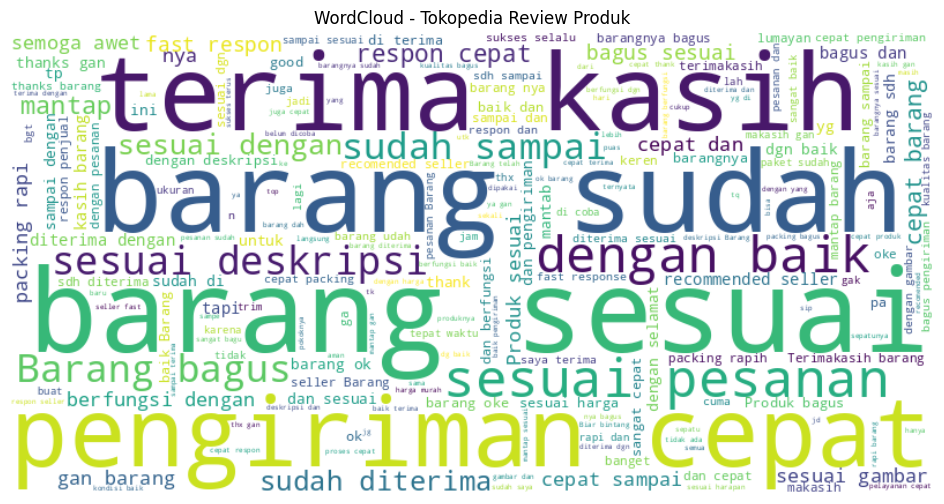

In [78]:
# menampilkan WordCloud
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud - Tokopedia Review Produk")
plt.show()

Diatas adalah wordcloud dari keseluruhan sentimen (positif, negatif maupun netral). Wordcloud ini menggambarkan kata yang sering muncul dalam ulasan produk.

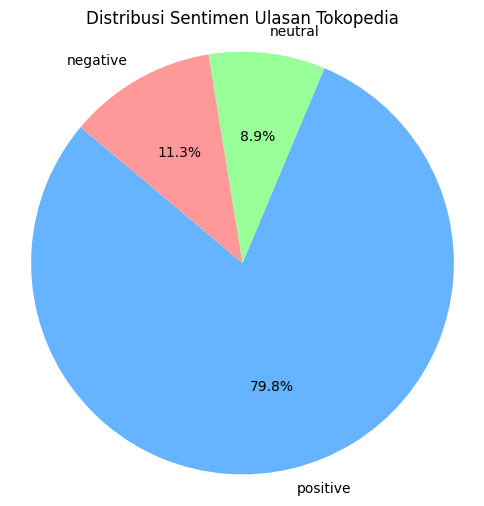

In [79]:
import matplotlib.pyplot as plt

# menghitung jumlah masing-masing label sentimen dan konversi ke Pandas DataFrame
sentiment_counts = df_final.groupBy("sentiment").count().toPandas()

# pie chart
plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts['count'],
        labels=sentiment_counts['sentiment'],
        autopct='%1.1f%%',
        startangle=140,
        colors=['#66b3ff','#99ff99','#ff9999'])  # pengaturan warna

plt.title('Distribusi Sentimen Ulasan Tokopedia')
plt.axis('equal')  # biar lingkarannya bulat
plt.show()


## Conclusion

Proyek ini menunjukkan bahwa model IndoBERT dapat digunakan secara efektif untuk analisis sentimen terhadap ulasan produk di Tokopedia. Dengan akurasi dan pemahaman konteks bahasa Indonesia yang tinggi, model ini mampu memberikan wawasan berharga mengenai pengalaman dan kepuasan pengguna.

Ke depannya, model ini dapat diintegrasikan ke dalam sistem monitoring produk atau dashboard analitik untuk membantu penjual dan platform dalam mengelola kualitas layanan.